In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 20090425

---

# Dealing with Missing Data

Missing data is a common problem in most real-world scientific datasets. While the best way for dealing with missing data will always be preventing their occurrence in the first place, it usually can't be helped, particularly when data are collected passively or voluntarily, or when data collection and recording is distributed among several people. 

For example, consider a survey dataset for some wildlife species:

| Count | Site | Observer | Temperature |
| ----- | ---- | -------- | ----------- |
| 15    | 1    | 1        | 15          |
| 10    | 1    | 2        | NA          |
| 6     | 1    | 1        | 11          |

Each row contains the number of individuals seen during the survey, along with three covariates: the site on which the survey was conducted, the observer that collected the data, and the temperature during the survey. If we are interested in modelling, say, population size as a function of the count and the associated covariates, it is difficult to accommodate the second observation because the temperature is missing (perhaps the thermometer was broken that day). Ignoring this observation will allow us to fit the model, but it wastes information that is contained in the other covariates.

There are a variety of ways for dealing with missing data, from the very naïve to the very sophisticated, and unfortunately the more common approaches tend to be *ad hoc* and will usually do more harm than good. 

### Example: Learning outcomes for hearing-impaired children

As a motivating example, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. 

![hearing aid](images/hearing_aid.jpg)

There is a suite of available predictors, including: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

In [2]:
test_scores = pd.read_csv('../data/test_scores.csv', index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


For three variables in the dataset, there are incomplete records.

In [3]:
test_scores.isnull().sum(0)

score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64

## Strategies for dealing with missing data

The easiest (and worst) way to deal with missing data is to **ignore it**. That is, simply run the analysis, missing values and all, hoping for the best. If your software is any good, this approach will simply not work; the algorithm will try to operate on data that includes missing values, and propagate them, resulting in statistics and estimates that cannot be calculated, which will typically raise errors. If your software is poor, it will make some assumption or decision about the missing values, and proceed to generate  results conditional on the assumption, which creates problems that may never be detected because no indication was given to any potential problem. 

The next easiest (worst) approach to analyzing data with missing values is to conduct list-wise deletion, by deleting the records that have missing values. This is called **complete case analysis**, because only records that are complete get retained for the analysis. The degree to which complete case analysis is undesirable depends on the mechanism by which data have become missing.

## Types of Missingness

- **Missing completely at random (MCAR)**: When data are MCAR, missing cases are, on average, identical to non-missing cases, with respect to the model. Ignoring the missingness will reduce the power of the analysis, but will not bias inference.
- **Missing at random (MAR)**: Missing data depends (usually probabilistically) on measured values, and hence can be modeled by variables observed in the data set. Accounting for the values which “cause” the missing data will produce unbiased results in an analysis.
- **Missing not at random (MNAR)**: Missing data depend on unmeasured or unknown variables. There is no information available to account for the missingness.

> Consider a medical dataset collected that records both age and number of current medications. In this dataset, age is recorded for all individuals, but number of meds is missing for some individuals.
> - if the probability of missingness is independent of both age and meds count, the data are MCAR (*missing at random, observed at random*)
> - if the probability of missingness depends on age but not on meds count, the data are MAR (*missing at random, not observed at random*)

The very best-case scenario for using complete case analysis, which corresponds to MCAR missingness, results in a **loss of power** due to the reduction in sample size. The analysis will lose the information contained in the non-missing elements of a partially-missing record. *Deletion of records due to partially-missing variables will always result in estimates that are inefficient.*

When data are not missing completely at random, inferences from complete case analysis may be **biased** due to systematic differences between missing and non-missing records that affects the estimates of key parameters. Here, we say that the missing data mechanism is **non-ignorable**.

**It is usually better to make up values for missing data than to throw real data away!**

When can record deletion be used?

- Data are missing completely at random
- Fraction of observations with missing elements is very small relative to overall sample size
- predictor and response variables are both absent

If the probability of missingnewss is related to the response variable, estimates can be badly biased. Its important to characterize the missingness in terms of the outcome of interest before deleting observations.

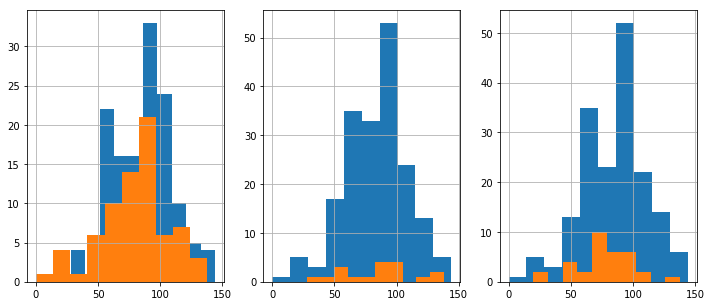

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12,5
                                       ))
for i,variable in enumerate(['mother_hs', 'prev_disab', 'family_inv']):
    (test_scores.assign(missing=test_scores[variable].isnull())
         .groupby('missing')
         .score.hist(ax=axes[i]))

## Imputation

To make our estimates as efficient as possible, **we want to preserve the information and interpretation of the non-missing data**.

One alternative to complete case analysis is to simply fill (*impute*) the missing values with a reasonable guess a the true value, such as the mean, median or modal value of the fully-observed records. This imputation, while not recovering any information regarding the missing value itself for use in the analysis, does provide a mechanism for including the non-missing values in the analysis, thereby making use of all available information.

Performing mean imputation is easy in Pandas, via the DataFrame/Series `fillna` method.

In [5]:
test_scores.siblings.mean()

1.1256038647342994

In [6]:
siblings_imputed = test_scores.siblings.fillna(test_scores.siblings.mean())

This approach may be reasonable under the MCAR assumption, but may induce bias under a MAR scenario, whereby missing values may **differ systematically** relative to non-missing values, making the particular summary statistic used for imputation *biased* as a mean/median/modal value for the missing values.

Beyond this, the use of a single imputed value to stand in place of the actual missing value glosses over the **uncertainty** associated with this guess at the true value. Any subsequent analysis procedure (*e.g.* regression analysis) will behave as if the imputed value were observed, despite the fact that we are actually unsure of the actual value for the missing variable. The practical consequence of this is that the variance of any estimates resulting from the imputed dataset will be **artificially reduced**.

## Multiple Imputation

One robust alternative to addressing missing data is **multiple imputation** (Schaffer 1999, van Buuren 2012). It produces unbiased parameter estimates, while simultaneously accounting for the uncertainty associated with imputing missing values. It is conceptually and mechanistically straightforward, and produces complete datasets that may be analyzed using any statistical methodology or software one chooses, as if the data had no missing values to begin with.

Multiple imputation generates imputed values based on a **regression model**. This regression model will help us generate reasonable values, particularly if data are MAR, since it uses information in the dataset that may be informative in predicting what the true value may be. Ideally, we want predictor variables that are **correlated** with the missing variable, and with the mechanism of missingness, if any. For example, one might be able to use test scores from one subject to predict missing test scores from another; or, the probability of income reporting to be missing may vary systematically according to the education level of the individual.

To see if there is any potential information among the variables in our dataset to use for imputation, it is helpful to calculate the pairwise correlation between all the variables. Since we have discrete variables in our data, the [Spearman rank correlation coefficient](http://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient) is appropriate.

In [7]:
test_scores.dropna().corr(method='spearman')

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
score,1.000000,0.073063,-0.085044,-0.539019,-0.278798,-0.184426,0.024057,0.140305,0.228500,0.222711,-0.345061
male,0.073063,1.000000,-0.072006,-0.008714,0.053338,-0.052054,-0.081165,0.031825,0.050372,-0.007690,-0.048638
siblings,-0.085044,-0.072006,1.000000,0.078471,-0.049989,-0.038020,0.104905,-0.003689,0.096268,0.077318,0.006234
family_inv,-0.539019,-0.008714,0.078471,1.000000,0.221696,0.082314,-0.029120,-0.092815,-0.358898,0.006370,0.401617
non_english,-0.278798,0.053338,-0.049989,0.221696,1.000000,-0.021996,0.068095,-0.047775,-0.199639,-0.015812,0.225428
prev_disab,-0.184426,-0.052054,-0.038020,0.082314,-0.021996,1.000000,0.136604,0.048132,0.137893,0.046592,-0.021367
age_test,0.024057,-0.081165,0.104905,-0.029120,0.068095,0.136604,1.000000,-0.122811,0.016760,0.033789,0.068430
non_severe_hl,0.140305,0.031825,-0.003689,-0.092815,-0.047775,0.048132,-0.122811,1.000000,-0.015996,0.008211,0.028480
mother_hs,0.228500,0.050372,0.096268,-0.358898,-0.199639,0.137893,0.016760,-0.015996,1.000000,0.024411,-0.214209
early_ident,0.222711,-0.007690,0.077318,0.006370,-0.015812,0.046592,0.033789,0.008211,0.024411,1.000000,-0.022854


We will try to impute missing values the mother's high school education indicator variable, which takes values of 0 for no high school diploma, or 1 for high school diploma or greater. The appropriate model to predict binary variables is a **logistic regression**. 

To keep things simple, we will only use variables that are themselves complete to build the predictive model, hence our subset of predictors will exclude family involvement score (`family_inv`) and previous disability (`prev_disab`).

In [8]:
impute_subset = test_scores.drop(labels=['family_inv','prev_disab','score'], axis=1)

In [9]:
y = impute_subset.pop('mother_hs').values
X = impute_subset.astype(float)

The *training* and *test* sets in this case will be the non-missing and missing values, respectively, since we want to use supervised learning to build our predictive model.

In [10]:
missing = np.isnan(y)

Next, we create a logistic regression model, and fit it using the non-missing observations.

As a performance hack, we will normalize the input variables (center them and subtract by their respective standard deviations). This will make the models run faster.

In [11]:
normalize = lambda x: (x - x.mean()) / x.std()
X = X.apply(normalize)

Now, we can set up our logistic regression model in PyMC3, as we have done previously.

In [12]:
from pymc3 import Model, Normal, Bernoulli, invlogit

with Model() as model:

    μ = Normal('μ', 0, sd=10)
    β = Normal('β', 0, sd=10, shape=X.shape[1])

    p = invlogit(μ + β.dot(X[~missing].T))

    mother_hs = Bernoulli('mother_hs', p, observed=y[~missing])

Notice that we have indexed out the non-missing values from `X` and `y`. 

We need to add one additional component to our model: **predictions for the unobserved values**. We can do this by creating a `Deterministic` node that calculates the expected probability at the missing values for high school education:

In [13]:
from pymc3 import Deterministic

with model:
    
    p_pred = Deterministic('p_pred', 
                    invlogit(μ + β.dot(X.loc[missing].T)))

This generates samples from the **posterior predictive distribution** for `p`, the same mechanism we used when peforming model checking.

We can now run our model and extract the predictions.

In [14]:
from pymc3 import fit

with model:
    
    tr = fit(20000, random_seed=RANDOM_SEED).sample(500)

Average Loss = 109.18: 100%|██████████| 20000/20000 [00:02<00:00, 9685.47it/s] 
Finished [100%]: Average Loss = 109.18


In [15]:
tr['p_pred'].mean(0)

array([ 0.77185554,  0.46366082,  0.69227549,  0.79256812,  0.42083697,
        0.53936998,  0.80524387,  0.49734257,  0.81899292,  0.58292826,
        0.71277124,  0.55940473,  0.76080566,  0.65288601,  0.79873058,
        0.50568591,  0.82814364,  0.4712178 ,  0.71263727,  0.73398766,
        0.74553918,  0.67907498,  0.77919538,  0.69435048,  0.50649043,
        0.7456188 ,  0.40491748,  0.83531538,  0.85419456,  0.77355884,
        0.76357147,  0.69907599,  0.50168539,  0.63739584,  0.4262249 ,
        0.52163027,  0.73131633,  0.75121597,  0.71835811,  0.69227549,
        0.42865549,  0.67278392,  0.7005504 ,  0.79288964,  0.59280548,
        0.77779468,  0.63592453,  0.82996551,  0.68868687,  0.71950342,
        0.41896307,  0.58117537,  0.84465594,  0.74923002,  0.84542377,
        0.69553836,  0.84106226,  0.43771244,  0.68513284,  0.54805074,
        0.54001904,  0.78759293,  0.78740536,  0.7612674 ,  0.84072848,
        0.64402648,  0.73337787,  0.79108273,  0.49285189,  0.82

These are *probabilities* of having a high school education; we need to use these in conjunction with a classification rule in order to create imputed values. We will assume `mother_hs=1` if the probability exceeds 0.5, or `mother_hs=0` otherwise.

In [16]:
(tr['p_pred'].mean(0) > 0.5).astype(int)

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1])

These values can then be inserted in place of the missing values, and an analysis can be performed on the entire dataset.

However, this is still just a single imputation for each missing value, and hence glosses over the uncertainty associated with the derivation of the imputes. Multiple imputation proceeds by **imputing several values**, to generate several complete datasets and performing the same analysis on all of them. With a set of estimates in hand, an *average* estimate of model parameters can be obtained that more adequately accounts for the uncertainty, hopefully providing more robust inference than from a single impute.

There are a variety of ways to generate multiple imputations. Here, we will define a *set* of predictive models. For example, we can pick arbitrary subsets of the predictor variables and use each subset to generate a vector of imputed values.

For efficiency, we will wrap a general model specification in a function, which can be instantiated with any subset of covariatest that we specify.

In [17]:
def imputation_model(predictors):

    with Model() as model:

        μ = Normal('μ', 0, sd=10)
        β = Normal('β', 0, sd=10, shape=len(predictors))

        p = invlogit(μ + β.dot(X.loc[~missing, predictors].T))

        mother_hs = Bernoulli('mother_hs', p, observed=y[~missing])

        p_pred = Deterministic('p_pred', 
                        invlogit(μ + β.dot(X.loc[missing, predictors].T)))
        
    return model

Surprisingly few imputations are required to acheive reasonable estimates, with 3-10 usually sufficient. We will use 3.

In [18]:
predictors = (['non_english', 'age_test', 'non_severe_hl'],
              ['male', 'siblings', 'non_english'],
              X.columns)

Let's run each of these models in turn and save the imputed values.

In [19]:
mother_hs_imp = []

for P in predictors:
    
    mod = imputation_model(P)
    
    with mod:
    
        tr = fit(20000, random_seed=RANDOM_SEED).sample(500)

    imputed = (tr['p_pred'].mean(0) > 0.5).astype(int)
    
    mother_hs_imp.append(imputed)

Average Loss = 94.925: 100%|██████████| 20000/20000 [00:01<00:00, 11133.77it/s]
Finished [100%]: Average Loss = 94.925
Average Loss = 94.783: 100%|██████████| 20000/20000 [00:01<00:00, 12270.39it/s]
Finished [100%]: Average Loss = 94.785
Average Loss = 109.18: 100%|██████████| 20000/20000 [00:01<00:00, 11348.17it/s]
Finished [100%]: Average Loss = 109.18


In [20]:
mother_hs_imp

[array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1]),
 array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]),
 array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1])]

Now we can perform 3 separate analyses, using the method of our choice, each based upon a different set of imputed values. 

In [21]:
from pymc3 import HalfCauchy

coefficients = []

for imputes in mother_hs_imp:
        
    X = test_scores.drop(labels=['family_inv','prev_disab'], axis=1).astype(float)
    X.loc[missing, 'mother_hs'] = imputes
    y = X.pop('score')
    
    with Model():

        μ = Normal('μ', 0, sd=10)
        β = Normal('β', 0, sd=10, shape=X.shape[1])
        
        σ = HalfCauchy('σ', 1)

        score = Normal('score', μ + β.dot(X.apply(normalize).T), sd=σ, observed=y)
        
        samples = fit(20000, random_seed=RANDOM_SEED).sample(1000)

    coefficients.append(samples['β'].mean(0))

Average Loss = 1,296.2: 100%|██████████| 20000/20000 [00:02<00:00, 9186.46it/s]  
Finished [100%]: Average Loss = 1,295.6
Average Loss = 1,296.2: 100%|██████████| 20000/20000 [00:01<00:00, 11414.65it/s]  
Finished [100%]: Average Loss = 1,295.6
Average Loss = 1,296.2: 100%|██████████| 20000/20000 [00:01<00:00, 10907.66it/s]  
Finished [100%]: Average Loss = 1,295.6


In [22]:
coeff_labels = ['male',
                'siblings',
                'non_english',
                'age_test',
                'non_severe_hl',
                'mother_hs',
                'early_ident',
                'non_white']

coef_df = pd.DataFrame(coefficients, columns=coeff_labels)
coef_df

,male,siblings,non_english,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,-0.356000,-1.445651,-2.857459,1.215705,2.349807,2.940681,2.910947,-3.127525
1,-0.576308,-1.718688,-3.040058,1.486784,2.391821,2.740079,2.824085,-3.169633
2,-0.572083,-1.659527,-2.997017,1.410336,2.437533,2.772642,2.830254,-3.148109


Inference for each coefficient is then based on the average of these three estimates.

In [23]:
coef_df.mean()

male            -0.501464
siblings        -1.607955
non_english     -2.964845
age_test         1.370942
non_severe_hl    2.393053
mother_hs        2.817801
early_ident      2.855095
non_white       -3.148422
dtype: float64

We can see that we obtain somewhat different estimates when we use multiple imputation versus complete case analysis:

In [24]:
X = test_scores.drop(labels=['family_inv','prev_disab'], axis=1).astype(float).dropna(0)
y = X.pop('score')

with Model():

    μ = Normal('μ', 0, sd=10)
    β = Normal('β', 0, sd=10, shape=X.shape[1])

    σ = HalfCauchy('σ', 1)

    score = Normal('score', μ + β.dot(X.apply(normalize).T), sd=σ, observed=y)

    samples = fit(20000, random_seed=RANDOM_SEED).sample(1000)
    
pd.Series(samples['β'].mean(0), index=coeff_labels)

Average Loss = 849.95: 100%|██████████| 20000/20000 [00:01<00:00, 10927.23it/s]   
Finished [100%]: Average Loss = 849.53


male             0.944586
siblings        -2.162773
non_english     -2.704296
age_test         1.384706
non_severe_hl    2.326195
mother_hs        3.168774
early_ident      3.165545
non_white       -3.155507
dtype: float64

Estimates from mean imputation are more similar.

In [25]:
X = test_scores.drop(labels=['family_inv','prev_disab'], axis=1).astype(float)
X['mother_hs'] = X.mother_hs.fillna(X.mother_hs.mean())
y = X.pop('score')

with Model():

    μ = Normal('μ', 0, sd=10)
    β = Normal('β', 0, sd=10, shape=X.shape[1])

    σ = HalfCauchy('σ', 1)

    score = Normal('score', μ + β.dot(X.apply(normalize).T), sd=σ, observed=y)

    samples = fit(20000, random_seed=RANDOM_SEED).sample(1000)
    
pd.Series(samples['β'].mean(0), index=coeff_labels)

Average Loss = 1,296.2: 100%|██████████| 20000/20000 [00:01<00:00, 10128.39it/s]  
Finished [100%]: Average Loss = 1,295.6


male            -0.387961
siblings        -1.504720
non_english     -3.135256
age_test         1.492877
non_severe_hl    2.347635
mother_hs        2.925255
early_ident      2.862539
non_white       -3.202634
dtype: float64

### Integrated missing data imputation

A more "fully Bayesian" approach for multiple imputation is to treat the missing values as latent variables, and estimate them just as one would with any other model unknown. This allows imputation to occur within the same modeling framework as the regession analysis itself. However, it involves constructing a sub-model for the missing data, which requires a little additional work.

Let's first extract `mother_hs` from the dataset:

In [26]:
X = test_scores.drop(labels=['family_inv','prev_disab'], axis=1).astype(float)
y = X.pop('score')
mother_hs_ = X.pop('mother_hs')

If we provide a model for `mother_hs`, PyMC will automatically impute values as it draws posterior samples.

In [27]:
mother_hs_.head(10)

0     NaN
1     0.0
2     NaN
3     1.0
5     NaN
6     NaN
7     1.0
9     0.0
10    NaN
12    1.0
Name: mother_hs, dtype: float64

For simplicity, here we will assume `mother_hs` is MCAR. So, all that is required is a sampling distribution for the variable, which is binary. So, an appropriate model is the Bernoulli distribution, just as we used for the likelihood in the logistic regression model.

We will assign a uniform prior to the probability of the mother having at least a high school education. Here is the complete model:

In [28]:
from pymc3 import Uniform, sample

with Model() as bayes_impute:
    
    π = Uniform('π', 0, 1)
    mother_hs = Bernoulli('mother_hs', π, observed=mother_hs_)
    
    μ = Normal('μ', 0, sd=10)
    β = Normal('β', 0, sd=10, shape=X.shape[1])
    γ = Normal('γ', 0, sd=10)

    σ = HalfCauchy('σ', 1)

    score = Normal('score', μ + β.dot(X.apply(normalize).T) + γ*mother_hs, sd=σ, observed=y)

    samples = sample(1000, tune=1000)

Assigned NUTS to π_interval__
Assigned BinaryGibbsMetropolis to mother_hs_missing
Assigned NUTS to μ
Assigned NUTS to β
Assigned NUTS to γ
Assigned NUTS to σ_log__
100%|██████████| 2000/2000 [00:42<00:00, 46.94it/s]


In [30]:
samples['mother_hs_missing'].mean(0)

array([ 0.34 ,  0.799,  0.527,  0.72 ,  0.682,  0.872,  0.606,  0.829,
        0.79 ,  0.636,  0.694,  0.772,  0.49 ,  0.594,  0.388,  0.333,
        0.612,  0.17 ,  0.831,  0.507,  0.853,  0.792,  0.85 ,  0.268,
        0.285,  0.801,  0.583,  0.638,  0.196,  0.817,  0.925,  0.782,
        0.845,  0.685,  0.612,  0.59 ,  0.559,  0.705,  0.746,  0.579,
        0.788,  0.751,  0.835,  0.678,  0.834,  0.836,  0.837,  0.759,
        0.805,  0.783,  0.833,  0.801,  0.914,  0.919,  0.553,  0.653,
        0.792,  0.663,  0.54 ,  0.806,  0.805,  0.918,  0.75 ,  0.608,
        0.405,  0.538,  0.497,  0.915,  0.732,  0.686,  0.626,  0.844,
        0.777])

The MCAR assumption can be relaxed and replaced by a more sophisticated model than the simpl Bernoulli sampling distribtion used here. In fact, we could implement the full multivariate model that we used for multiple imputation relatively easily.

## Capstone Project

To consolidaate what we've learned here, let's consider the problem of predicting survival in the Titanic disaster, based on our available information. Here, we want to predict survival as a function of several variables that are available from the ship's record.

![titanic](images/titanic_cube.png)

In [31]:
titanic = pd.read_excel("../data/titanic.xls", "titanic")
titanic.name

0                           Allen, Miss. Elisabeth Walton
1                          Allison, Master. Hudson Trevor
2                            Allison, Miss. Helen Loraine
3                    Allison, Mr. Hudson Joshua Creighton
4         Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
5                                     Anderson, Mr. Harry
6                       Andrews, Miss. Kornelia Theodosia
7                                  Andrews, Mr. Thomas Jr
8           Appleton, Mrs. Edward Dale (Charlotte Lamson)
9                                 Artagaveytia, Mr. Ramon
10                                 Astor, Col. John Jacob
11      Astor, Mrs. John Jacob (Madeleine Talmadge Force)
12                          Aubart, Mme. Leontine Pauline
13                           Barber, Miss. Ellen "Nellie"
14                   Barkworth, Mr. Algernon Henry Wilson
15                                    Baumann, Mr. John D
16                               Baxter, Mr. Quigg Edmond
17        Baxt

Fit a reasonable Bayesian multivariate generalized linear model with this data, using several variables such as sex, age and fare to predict survival. Make sure you involve the following steps:

- data imputation
- model checking
- model comparison

In [32]:
# Write your answer here

## References

- R. J. A. Little and D. B. Rubin. Statistical Analysis with Missing Data. Wiley, New York, second edition, 2002.
- M. J. Knol, K. J. M. Janssen, R. T. Donders, A. C. G. Egberts, E. R. Heerding, D. E. Grobbee, K. G. M. Moons, and M. I. Geerlings. [Unpredictable bias when using the missing indicator method or complete case analysis for missing confounder values: an empirical example](https://www.ncbi.nlm.nih.gov/pubmed/20346625). J Clin Epi, 63:728–736, 2010.
- van Buuren, S. (2012). Flexible Imputation of Missing Data (pp. 1–326).
- Schafer, J. L. (1999). Multiple imputation: a primer. Statistical Methods in Medical Research, 8(1), 3–15. http://doi.org/10.1177/096228029900800102